In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain

from monte_carlo_return import (
    generate_bet_return,
    compute_objective_via_simulation,
    minimize_simulation,
    INDEX_TO_SCENARIO
)
from analytical_return import (
    expectation,
    second_moment,
    variance,
    compute_objective_via_analytical,
    minimize_analytical,
    softmax,
)
from data import (
    load_metadata_artefacts,
    load_odds,
    join_metadata,
    build_empty_dataframe,
    apply_final_treatment,
)
from GameProbs import GameProbs
from utils import get_scenarios
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
metadata, gameid_to_outcome = load_metadata_artefacts("data/metadata.parquet")
odds = load_odds("data/odds.parquet")
print(metadata.shape)
print(odds.shape)

(16898, 8)
(2003933, 7)


## Create bets dataframe for a game
Now, we create a bets dataframe for the game, considering multiple Sportsbooks, except the one used for the real probabilities.

In [4]:
GAME_ID = "5254998" # Chapecoense x Flamengo
my_game = GameProbs(GAME_ID) 
df = my_game.build_dataframe()
df

,0,1,2,3,4,5,6
0,0.0289,0.0216,0.0100,0.0033,0.0008,0.0002,0.0000
1,0.0632,0.0598,0.0239,0.0076,0.0019,0.0004,0.0001
2,0.0880,0.0717,0.0354,0.0097,0.0024,0.0005,0.0001
3,0.0873,0.0688,0.0292,0.0108,0.0022,0.0004,0.0001
4,0.0692,0.0529,0.0220,0.0066,0.0022,0.0003,0.0001
5,0.0466,0.0347,0.0142,0.0042,0.0010,0.0004,0.0000
6,0.0558,0.0398,0.0158,0.0045,0.0011,0.0002,0.0001


In [5]:
# Example of match that has 46 options of exact result bet 
sportsbook_list = ['1xBet',
                   'Megapari Sport',
                   'NetBet',
                   'Betobet',
                   '18Bet',
                   'Mr Green Sport',
                   'Parimatch',
                   'Bet365']
odds_sample = odds[(odds.Sportsbook.isin(sportsbook_list))&(odds.GameId==GAME_ID)]

# Join metadata info to the odds dataframe
odds_sample = join_metadata(odds_sample, metadata)
print(odds_sample.shape)

(680, 9)


In [6]:
odds_sample = apply_final_treatment(df_odds=odds_sample, df_real_prob=df)
odds_sample

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,BetMap,real_prob,bet_flag
4,5254998,1xBet,exact,0 : 4,o,15.0,0.066667,Chapecoense,Flamengo,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0692,True
5,5254998,1xBet,exact,0 : 5,o,41.0,0.024390,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0466,True
6,5254998,1xBet,exact,0 : 6,o,101.0,0.009901,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0558,True
12,5254998,1xBet,exact,1 : 5,o,51.0,0.019608,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.0347,True
13,5254998,1xBet,exact,1 : 6,o,126.0,0.007937,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.0398,True
...,...,...,...,...,...,...,...,...,...,...,...,...
476,5254998,Bet365,over/under,5.5,over,11.0,0.090909,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.2200,True
478,5254998,Bet365,over/under,6.5,over,21.0,0.047619,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.0939,True
480,5254998,Bet365,over/under,7.5,over,51.0,0.019608,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0305,True
490,5254998,Bet365,spread,+1/-1,away,2.0,0.500000,Chapecoense,Flamengo,"[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...",0.6049,True


## Bet Allocation (F2)

In [7]:
odds_sample = odds_sample[odds_sample.Market.isin(['exact', 'both_score'])].reset_index()
print(odds_sample.shape)

(54, 13)


In [9]:
n = len(odds_sample)
allocation_array = np.round(np.array(((1/n), ) * n), 4)
allocation_array

array([0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185])

In [10]:
#df_log = build_empty_dataframe(7, 7, 0)

In [11]:
#odds_sample_favorable['allocation_array'] = allocation_array

In [15]:
#allocation_array = solution
financial_return_array = generate_bet_return(df_prob=df,
                                             df_bet=odds_sample,
                                             num_simulations=20000,
                                             allocation_array=allocation_array)
financial_return_array                                             

sampled_result: 1 : 1 ---- financial_return: 0.30635999999999997
sampled_result: 0 : 3 ---- financial_return: 0.0
sampled_result: 0 : 6 ---- financial_return: 9.841999999999999
sampled_result: 1 : 2 ---- financial_return: 0.30635999999999997
sampled_result: 1 : 2 ---- financial_return: 0.30635999999999997
sampled_result: 1 : 2 ---- financial_return: 0.30635999999999997
sampled_result: 0 : 2 ---- financial_return: 0.0
sampled_result: 1 : 6 ---- financial_return: 12.25736
sampled_result: 1 : 5 ---- financial_return: 5.74536
sampled_result: 1 : 4 ---- financial_return: 1.0833599999999999
sampled_result: 1 : 5 ---- financial_return: 5.74536
sampled_result: 0 : 2 ---- financial_return: 0.0
sampled_result: 2 : 3 ---- financial_return: 0.30635999999999997
sampled_result: 1 : 4 ---- financial_return: 1.0833599999999999
sampled_result: 1 : 4 ---- financial_return: 1.0833599999999999
sampled_result: 1 : 2 ---- financial_return: 0.30635999999999997
sampled_result: 0 : 6 ---- financial_return: 9.8

array([0.30636, 0.     , 9.842  , ..., 0.30636, 0.30636, 1.08336])

In [16]:
print(np.mean(financial_return_array))
print(np.std(financial_return_array))

2.1003922459999997
3.993749098151589


In [14]:
#4.3267728000000005 / 5.370238491052344
#3.3057165240609123 / 2.4691537702461703
#3.666701490280025 / 3.34370661472899
#3.0827736576503217 / 2.2487296065006084
#2.4384799999999998/4.789840171780265
#1.5011996815226962/2.148751477147124
1.198463568761181/0.792960103082686

1.5113794049688918

In [16]:
from monte_carlo_return import get_favorable_scenarios
x = get_favorable_scenarios(odds_sample.BetMap[3])
y = get_favorable_scenarios(odds_sample.BetMap[21])

In [17]:
event_i = odds_sample.BetMap[3]
event_j = odds_sample.BetMap[21]
print(np.transpose(np.array(event_i).reshape(7,7)) * np.transpose(np.array(event_j).reshape(7,7)) * df.to_numpy())

[[0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0347 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]]


In [17]:
odds_favorable = np.array(odds_sample['Odd'])
real_prob_favorable = np.array(odds_sample['real_prob'])
#scenario_favorable = np.array(odds_sample_favorable['Bet'])
event_favorable = list(odds_sample['BetMap'].values)

my_expectation = expectation(allocation_array, odds_favorable, real_prob_favorable)
print(f"my_expectation: {my_expectation}")

my_second_moment = second_moment(allocation_array, odds_favorable, real_prob_favorable, event_favorable, df)
print(f"my_second_moment: {my_second_moment}")

my_sigma = np.sqrt(variance(my_second_moment, my_expectation))

print(f"my_sigma: {my_sigma}")

my_expectation: 2.1330399360000003
my_second_moment: 20.57362060140896
my_sigma: 4.002969052195891


## Financial Return (F3)

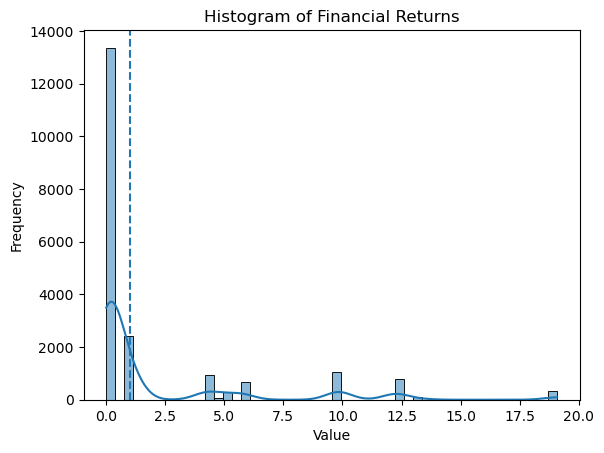

In [18]:
cost = 1
result = financial_return_array - cost

# Plot a histogram using Seaborn
sns.histplot(financial_return_array, bins=50, kde=True)

# Add a vertical line
plt.axvline(x=cost, linestyle='--')
#plt.axvline(x=0, linestyle='--')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Financial Returns')

# Show the plot
plt.show()

In [20]:
# compute_objective_via_simulation(x=allocation_array,
#                                  df_prob=df,
#                                  df_bet=odds_sample_favorable,
#                                  num_simulations=50000)

In [21]:
allocation_array

array([0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185])

In [19]:
compute_objective_via_analytical(x=allocation_array,
                                 public_odd=odds_favorable,
                                 real_probabilities=real_prob_favorable,
                                 event=event_favorable,
                                 df_prob=df)

-0.5328644584024169

In [23]:
# solution = minimize_simulation(df_prob=df,
#                                df_bet=odds_sample_favorable,
#                                num_simulations=10000)

In [20]:
solution = minimize_analytical(public_odd=odds_favorable,
                               real_probabilities=real_prob_favorable,
                               event=event_favorable,
                               df_prob=df)

Optimization terminated successfully.
         Current function value: -1.489967
         Iterations: 25
         Function evaluations: 1595
         Gradient evaluations: 29


In [21]:
print(sum(solution))
solution = softmax(solution)
print(sum(solution))

-0.00033526931729577214
1.0000000000000002


In [22]:
solution

array([3.03115363e-02, 5.50187685e-03, 2.73747474e-03, 1.15332089e-03,
       4.50133322e-04, 1.49647461e-03, 4.13263849e-05, 1.70001828e-01,
       3.03116135e-02, 6.64291618e-03, 3.63724274e-03, 2.28515123e-03,
       1.50051366e-03, 1.09567392e-03, 2.21963055e-04, 9.52361549e-04,
       7.35072332e-02, 6.49510267e-03, 2.51577443e-03, 1.57938920e-03,
       5.65051111e-04, 1.00369108e-01, 6.43673535e-03, 3.58900411e-03,
       1.74482541e-03, 1.07930396e-03, 6.60313206e-05, 6.51019481e-02,
       3.03116324e-02, 6.64292477e-03, 3.63724357e-03, 2.28518282e-03,
       1.50051291e-03, 1.09567431e-03, 2.21963135e-04, 9.52367123e-04,
       7.35078435e-02, 3.03116290e-02, 5.50188488e-03, 2.73746529e-03,
       1.15331960e-03, 4.50135534e-04, 1.49647365e-03, 4.13264195e-05,
       1.70002382e-01, 6.64291872e-03, 3.52659356e-03, 1.70260457e-03,
       8.87691174e-04, 1.85052723e-03, 6.45711368e-05, 1.87881849e-03,
       6.51025541e-02, 6.51028465e-02])

In [23]:
odds_sample[['Market', 'Sportsbook', 'Scenario', 'Odd', 'public_prob', 'real_prob']].assign(solution=np.round(solution, 3)).sort_values(['solution'], ascending=False)
#odds_sample[['Market', 'Scenario', 'Odd', 'public_prob', 'real_prob', 'bet_flag']].assign(solution=solution)

,Market,Sportsbook,Scenario,Odd,public_prob,real_prob,solution
7,both_score,1xBet,,2.20,0.454545,0.5251,0.170
44,both_score,Megapari Sport,,2.20,0.454545,0.5251,0.170
21,both_score,NetBet,,2.10,0.476190,0.5251,0.100
36,both_score,18Bet,,2.03,0.492611,0.5251,0.074
16,both_score,Betobet,,2.03,0.492611,0.5251,0.074
27,both_score,Parimatch,,2.00,0.500000,0.5251,0.065
52,both_score,Mr Green Sport,,2.00,0.500000,0.5251,0.065
53,both_score,Bet365,,2.00,0.500000,0.5251,0.065
8,exact,Betobet,0 : 4,15.00,0.066667,0.0692,0.030
28,exact,18Bet,0 : 4,15.00,0.066667,0.0692,0.030
